# Testing Pipeline for a PyTorch Model

### Imports
Import drive if using collab

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
import tqdm
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import glob
from PIL import Image
import io

### Print PyTorch versions and Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Device:", device)

PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113
Device: cuda:0


### Specify some variables

In [4]:
weights_path = "../weights/fire_detection_densenet_10epochs.pt"
data_dir = "../datasets/final_dataset/val/"
num_classes = 4
batch_size = 16
model_name = "densenet"

my_labels={
    'fire': 0,
    'like-smoke': 1,
    'no-fire': 2,
    'smoke': 3
}

### Helper Functions

In [5]:
def plot_confusion_matrix(conf_mat):
    classes = list(my_labels.keys())
    df_cm = pd.DataFrame(conf_mat, classes, classes)
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

# Testing

### Load Model

In [6]:
model_ft = models.densenet121()
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)
input_size = 224

model_ft.load_state_dict(torch.load(weights_path))
model_ft = model_ft.to(device)
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Load Data

In [7]:
data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
test_data =  datasets.ImageFolder(data_dir, data_transforms)
test_data = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Initializing Datasets and Dataloaders...


### Pipeline

In [8]:
def test_batch(model, test_data):
    model.eval()   # Set model to evaluate mode

    pred_list = list()
    label_list = list()

    # Iterate over data.
    for inputs, labels in tqdm.notebook.tqdm(test_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        pred_list.append(preds)
        label_list.append(labels)

    return np.concatenate(pred_list), np.concatenate(label_list)

def test_single_image(model, image_path):
    model.eval()   # Set model to evaluate mode

    test_data = Image.open(image_path)
    test_data = test_data.convert('RGB')
    test_data = data_transforms(test_data)
    test_data = [(test_data, -1)]
    test_batch = torch.utils.data.DataLoader(test_data, batch_size=1)

    preds = ...

    for inputs, _ in test_batch:
        inputs = inputs.to(device)
        inputs = inputs.float() # byte type to float

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        preds = preds.detach().cpu().numpy()

    return preds[0]

def test_and_show_image(model, image, name=None):
    pred = test_single_image(model, image)
    pred = list(my_labels.keys())[list(my_labels.values()).index(pred)] # get key from value in dict
    
    print("Prediction:", pred)
    
    if not name:
        print("Image name:", image)
    else:
        print("Image name:", name)

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.grid(False)
    plt.imshow(img)
    plt.show()

In [9]:
preds, labels = test_batch(model_ft, test_data)

  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy: 99.6947 %


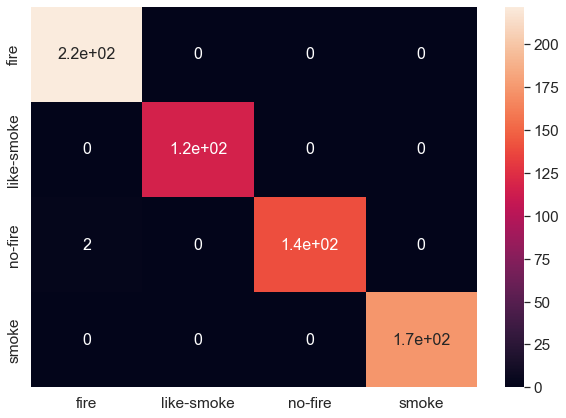

In [10]:
cfn_matrix = confusion_matrix(labels, preds)
acc = accuracy_score(labels, preds) * 100
print(f'Accuracy: {acc:.4f} %')
plot_confusion_matrix(cfn_matrix)

Prediction: fire
Image name: fire-1.png


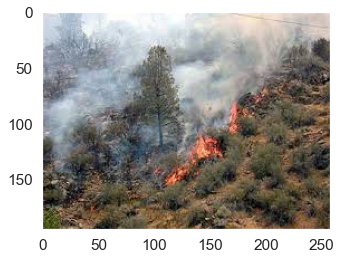

Prediction: fire
Image name: fire-2.jpg


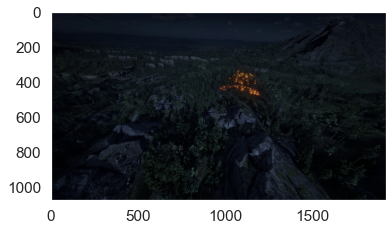

Prediction: like-smoke
Image name: like-smoke1.jpg


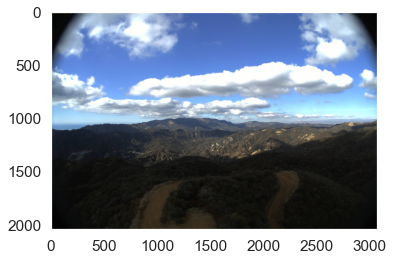

Prediction: like-smoke
Image name: like-smoke2.jpg


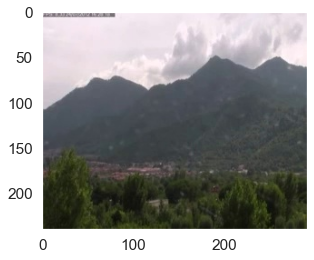

Prediction: no-fire
Image name: mountain.jpg


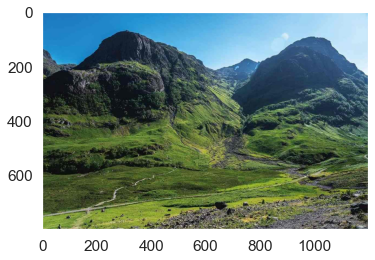

Prediction: no-fire
Image name: mountain2.jpg


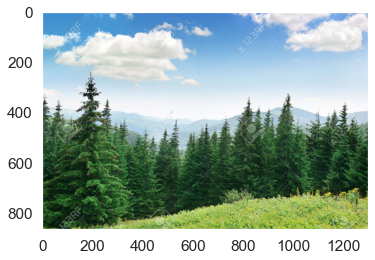

Prediction: no-fire
Image name: no-fire1.jpg


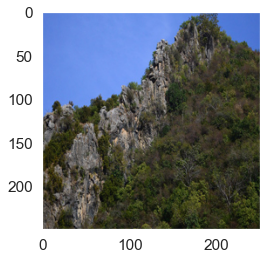

Prediction: no-fire
Image name: no-fire2.jpg


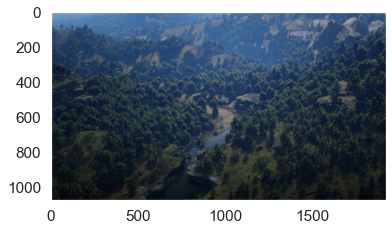

Prediction: smoke
Image name: smoke1.jpg


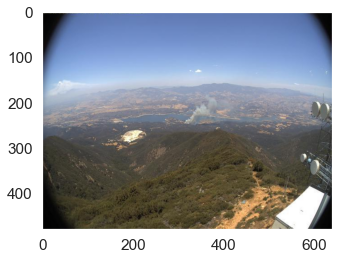

Prediction: smoke
Image name: smoke2.jpg


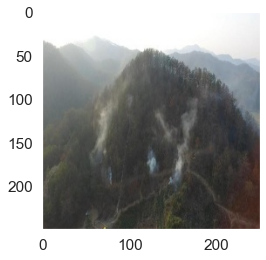

Prediction: smoke
Image name: smoke3.jpg


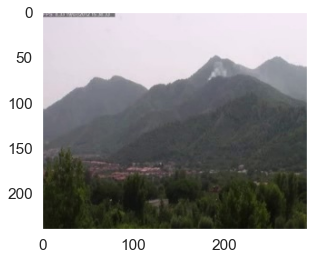

Prediction: smoke
Image name: smoke4.jpg


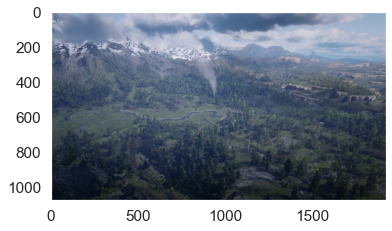

Prediction: no-fire
Image name: smoke5.jpg


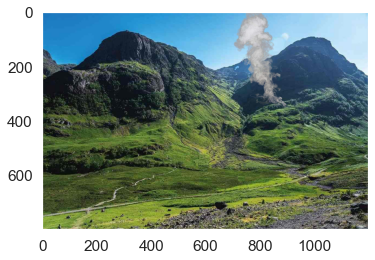

Prediction: fire
Image name: smoke6.png


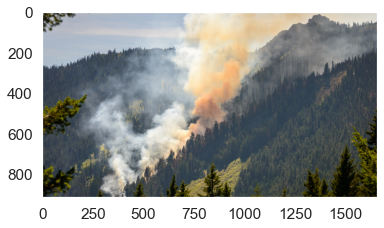

Prediction: fire
Image name: smoke7.png


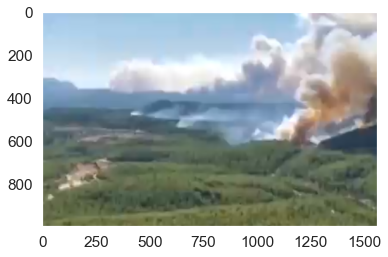

Prediction: no-fire
Image name: smoke8.jpg


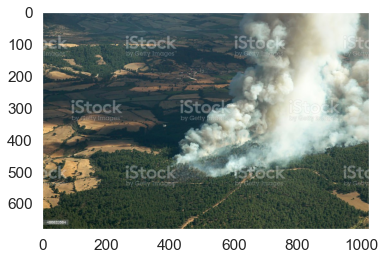

In [13]:
FOLDER_PATH = "../test/densenet_test/"
single_images = os.listdir(FOLDER_PATH)

for img in single_images:
    path = FOLDER_PATH + img
    pred = test_and_show_image(model_ft, path, name=img)
